# 分割 double 

In [1]:
from testing import viz_expr # 可视化 relay

In [2]:
import tvm
from tvm import relay
from tvm.relay.dataflow_pattern import *

构建计算图：

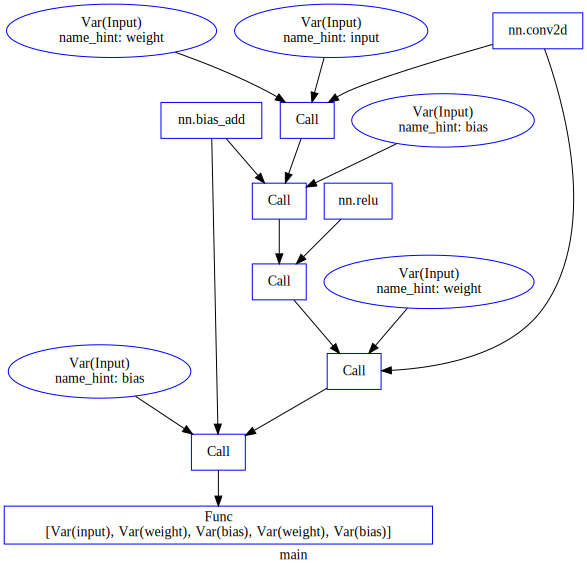

In [3]:
# Graph
x = relay.var("input")
w = relay.var("weight")
b = relay.var("bias")
w2 = relay.var("weight")
b2 = relay.var("bias")
conv2d = relay.op.nn.conv2d(x, w)
bias_add = relay.op.nn.bias_add(conv2d, b)
relu = relay.op.nn.relu(bias_add)
conv2d2 = relay.op.nn.conv2d(relu, w2)
bias_add2 = relay.op.nn.bias_add(conv2d2, b2)
viz_expr(bias_add2)

In [4]:
print(tvm.IRModule.from_expr(bias_add2))

def @main(%input, %weight, %bias, %weight1, %bias1) {
  %0 = nn.conv2d(%input, %weight, padding=[0, 0, 0, 0]);
  %1 = nn.bias_add(%0, %bias);
  %2 = nn.relu(%1);
  %3 = nn.conv2d(%2, %weight1, padding=[0, 0, 0, 0]);
  nn.bias_add(%3, %bias1)
}



构建模式：

In [5]:
# Pattern 1
conv2d_p = is_op("nn.conv2d")(wildcard(), wildcard())
bias_add_p = is_op("nn.bias_add")(conv2d_p, wildcard())
relu_p = is_op("nn.relu")(bias_add_p)

分割计算图：

In [6]:
partitioned = bias_add2
for pat, label in [(relu_p, "conv_bias_relu"), (bias_add_p, "conv_bias")]:
    partitioned = pat.partition(partitioned, {"Composite": label})

In [7]:
print(tvm.IRModule.from_expr(partitioned))

def @main(%input, %weight, %bias, %weight1, %bias1) {
  %3 = fn (%FunctionVar_0_01, %FunctionVar_0_11, %FunctionVar_0_21, PartitionedFromPattern="nn.conv2d_nn.bias_add_nn.relu_", Composite="conv_bias_relu") {
    %1 = nn.conv2d(%FunctionVar_0_01, %FunctionVar_0_11, padding=[0, 0, 0, 0]);
    %2 = nn.bias_add(%1, %FunctionVar_0_21);
    nn.relu(%2)
  };
  %4 = %3(%input, %weight, %bias);
  %5 = fn (%FunctionVar_0_0, %FunctionVar_0_1, %FunctionVar_0_2, PartitionedFromPattern="nn.conv2d_nn.bias_add_", Composite="conv_bias") {
    %0 = nn.conv2d(%FunctionVar_0_0, %FunctionVar_0_1, padding=[0, 0, 0, 0]);
    nn.bias_add(%0, %FunctionVar_0_2)
  };
  %5(%4, %weight1, %bias1)
}

